In [225]:
import numpy as np
import pandas as pd
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [236]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
import time
import warnings

# 1. Data preprocessing

**1. Read data**

In [3]:
# Read Dataset
file_path = 'concrete_data.csv' # Replace with the actual path of the file you uploaded
df = pd.read_csv(file_path)

# Use the first 8 columns as input features X and the last column as target variable y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [4]:
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


**2. Data Normalization**

In [5]:
# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**3. Divide the training set and test set**

In [6]:
# Divide the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [7]:
print("X_train shape: ", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape:  (721, 8)
X_test shape: (309, 8)
y_train shape: (721,)
y_test shape: (309,)


# 2. ANN

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

In [9]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation_function='relu'):
        # Network layer structure
        self.layers = [input_size] + hidden_layers + [output_size]
        self.activation_function = self.get_activation_function(activation_function)
        
        # Initialize weights and biases
        self.weights = []  
        self.biases = []   
        
        for i in range(len(self.layers) - 1):
            # Xavier Initialization for weights
            n_in = self.layers[i]
            n_out = self.layers[i + 1]
            # Xavier normal distribution initialization
            self.weights.append(np.random.randn(n_in, n_out) * np.sqrt(1 / n_in))
            # Initialize bias to zero
            self.biases.append(np.zeros((1, n_out)))

    def get_activation_function(self, name):
        if name == "sigmoid":
            return sigmoid
        elif name == "relu":
            return relu
        elif name == "tanh":
            return tanh
        else:
            raise ValueError("Unknown activation function")

    def forward(self, X):
        """
        Forward propagation calculation
        X: Input data, shape is (number of samples, number of features)
        Return value: Output result, shape is (number of samples, number of neurons in the output layer)
        """
        A = X  # Input layer output
        for i in range(len(self.weights) - 1):
            Z = np.dot(A, self.weights[i]) + self.biases[i]  # Linear transformation
            A = self.activation_function(Z)  # Activation function
        # Output layer has no activation function
        output = np.dot(A, self.weights[-1]) + self.biases[-1]
        return output
    
    def to_genome(self):
        """
        Flatten the weights and biases into a one-dimensional array for genome representation
        :return: Flattened one-dimensional array
        """
        flattened_weights = [w.flatten() for w in self.weights]
        flattened_biases = [b.flatten() for b in self.biases]
        return np.concatenate(flattened_weights + flattened_biases)

    def from_genome(self, genome):
        """
        Restore the one-dimensional array of genomes to their original form of weights and biases
        :param genome: the flattened one-dimensional array
        """
        start = 0
        for i in range(len(self.weights)):
            # Restore weights
            weight_shape = self.weights[i].shape # 当前层的权重矩阵的形状
            weight_size = np.prod(weight_shape)
            self.weights[i] = genome[start:start + weight_size].reshape(weight_shape) # 截取例子向量中的一部分并复原成当前层权重矩阵的形状
            start += weight_size

        for i in range(len(self.biases)):
            # Restore bias
            bias_shape = self.biases[i].shape
            bias_size = np.prod(bias_shape)
            self.biases[i] = genome[start:start + bias_size].reshape(bias_shape)
            start += bias_size
            
    def get_bounds(self, bound_value=1):
        """
        Generate the search space range according to the structure of the neural network
        :param bound_value: The upper and lower bounds of the search space, for example [-bound_value, bound_value]
        :return: NumPy array, shape (dimensions, 2), each row represents [min, max]
        """
        genome_size = self.to_genome().size  # Get the total dimension of the genome
        bounds = np.array([[-bound_value, bound_value]] * genome_size)  # Set the same upper and lower bounds for each dimension
        return bounds

In [10]:
ann = NeuralNetwork(input_size=8, hidden_layers=[10, 20], output_size=1, activation_function='relu')

In [11]:
# Perform forward propagation
predictions = ann.forward(X_train)
print(predictions.shape)

(721, 1)


# 3. GA
1. 初始化种群
2. 更新初始种群的适应度值
3. REPEAT (循环，直到达到终止条件)  
    a. 选择父代个体（根据适应度）  
    b. 执行交叉操作，生成后代  
    c. 执行变异操作，改变后代基因  
    d. 更新后代适应度  
    e. 使用精英保留策略更新种群  
4. 返回最优解和相应的适应度


## 3.1 Indiavidual and Population

In [28]:
class Individual:
    def __init__(self, dimensions, bounds):
        """
        Initialize an individual in the population
        :param dimensions: the dimensions of the individual's genome (corresponding to the total number of weights and biases of the ANN)
        :param bounds: the search space range [(min, max), ...] the minimum and maximum values ​​of each dimension
        """
        # bounds_range = bounds[:, 1] - bounds[:, 0]
        self.bounds = bounds
        self.genome = np.random.uniform(bounds[:, 0], bounds[:, 1], dimensions)  # Randomly initialize the genome
        self.fitness = float('inf')  # Initialize fitness to infinity

In [103]:
class Population:
    def __init__(self, population_size, population=None, dimensions=dimensions, bounds=bounds):
        """
        Initialize the population
        :param population_size: the number of individuals in the population
        :param dimensions: the dimensions of each individual's genome
        :param bounds: the search space range [(min, max), ...] for each dimension
        """
        self.population_size = population_size
        self.dimensions = dimensions
        self.bounds = bounds

        # Initialize population
        if population == None:
            self.population = [Individual(dimensions, bounds) for _ in range(population_size)]
        else:
            self.population = population
            

    def update_fitness(self, fitness_function = fitness_function):
        """
        Update the fitness values of all individuals in the population.
        :param fitness_function: a callable fitness function that takes an individual's genome and additional arguments
        :ohter: arguments for the fitness function
        """
        for individual in self.population:
            # Compute fitness using the provided fitness function
            individual.fitness = fitness_function(individual.genome)

    def update_population(self, new_population):
        self.population = new_population

In [190]:
# 已经定义了适应度函数 fitness_function，神经网络模型 ann，训练数据 X_train 和 y_train
dimensions = ann.to_genome().size
bounds=np.array([[-1, 1]] * dimensions)

# 初始化种群
population = Population(50)

# 更新适应度
population.update_fitness()

# 查看适应度
for i, individual in enumerate(population.population[:5]):  # 打印前5个个体的适应度
    print(f"Individual {i} fitness: {individual.fitness}")

Individual 0 fitness: 0.6245432806395679
Individual 1 fitness: 0.5348416117295505
Individual 2 fitness: 0.4965159823060449
Individual 3 fitness: 0.5711351523428828
Individual 4 fitness: 0.5364562925254632


## 3.2 Fitness Functin

In [166]:
def fitness_function(individual_genome, ann=ann, X_train=X_train, y_train=y_train, lambda_reg=0.01):
    """
    Calculate fitness value (use MSE with L2 regularization for a neural network in GA)
    :param individual_genome: genome of the individual (expanded weight and bias array)
    :param ann: neural network model
    :param X_train: training set input
    :param y_train: training set output
    :param lambda_reg: regularization coefficient
    :return: fitness value (negative loss, higher is better for GA)
    """
    # Decode the individual's genome into weights and biases
    ann.from_genome(individual_genome)

    # Forward propagation, calculate predictions
    predictions = ann.forward(X_train)

    # Calculate mean square error (MSE)
    mse = np.mean((predictions - y_train) ** 2)

    # Calculate L2 regularization term
    l2_regularization = 0
    for w in ann.weights:
        l2_regularization += np.sum(w ** 2)

    # Total loss = MSE + regularization term
    total_loss = mse + lambda_reg * l2_regularization

    # Fitness: inverse of the total loss
    fitness = 1 / (1 + total_loss)
    return fitness*1000

In [167]:
individual_genome = np.random.uniform(-1, 1, dimensions)  # 随机生成个体基因
fitness = fitness_function(individual_genome, ann, X_train, y_train, lambda_reg=0.01)

print("Fitness value:", fitness)

Fitness value: 0.6402232630843612


## 3.3 Selection

选择策略解析
1. 轮盘赌选择（Roulette Wheel Selection）  
原理：
根据个体适应度值的比例进行选择。
适应度越高的个体被选择的概率越大。  
适用场景：
适合适应度值分布较均匀的情况。  
实现逻辑：
归一化适应度值作为概率分布。
按照该概率分布从种群中随机采样。  
2. 锦标赛选择（Tournament Selection）  
原理：
随机选出 tournament_size 个个体，从中选择适应度最高的个体。
重复该过程直到选出指定数量的个体。  
适用场景：
适合适应度分布差异较大的情况。
通过调整 tournament_size 可以平衡选择压力（较小的值增加随机性，较大的值更偏向精英选择）。
3. 排名选择（Rank Selection）  
原理：
根据适应度排序，分配选择概率：排名越高的个体被选择的概率越大。
适应度值被转换为排序指数，避免直接使用适应度值可能带来的不稳定性。  
适用场景：
当适应度值跨度较大或分布极不均匀时。
通过排序后的概率分配，可以避免过早收敛。

In [105]:
def selection(population, num_selected, strategy='roulette', tournament_size=3):
    """
    Select individuals from the population based on the specified strategy.
    :param population: Population object containing individuals and their fitness
    :param num_selected: Number of individuals to select
    :param strategy: Selection strategy ('roulette', 'tournament', 'rank')
    :param tournament_size: Number of participants in a tournament (used for 'tournament' strategy)
    :return: List of selected individuals
    """
    individuals = population.population  # 获取种群中的所有个体
    fitnesses = np.array([ind.fitness for ind in individuals])  # 获取所有个体的适应度值

    selected = []
    selected_indices = []

    if strategy == 'roulette':
        # Normalize fitness values to probabilities
        total_fitness = np.sum(fitnesses)
        
        if total_fitness == 0 or np.isnan(total_fitness):
            # If total fitness is zero or NaN, fall back to uniform random selection
            probabilities = np.ones(len(individuals)) / len(individuals)
        else:
            probabilities = fitnesses / total_fitness
    
        selected_indices = np.random.choice(len(individuals), size=num_selected, p=probabilities)
        selected = [individuals[i] for i in selected_indices]

    elif strategy == 'tournament':
        for _ in range(num_selected):
            # Randomly select 'tournament_size' individuals
            participants = np.random.choice(len(individuals), size=tournament_size, replace=False)
            # Select the best individual from participants
            best_index = participants[np.argmax([fitnesses[i] for i in participants])]
            selected_indices.append(best_index)
            selected.append(individuals[best_index])

    elif strategy == 'rank':
        # Sort individuals by fitness (descending order)
        ranked_indices = np.argsort(fitnesses)[::-1]
        # Assign selection probabilities based on rank
        ranks = np.arange(1, len(individuals) + 1)
        probabilities = ranks / np.sum(ranks)  # Higher rank gets higher probability
        selected_indices = np.random.choice(len(individuals), size=num_selected, p=probabilities)
        selected = [individuals[i] for i in selected_indices]

    else:
        raise ValueError("Invalid selection strategy. Choose from 'roulette', 'tournament', or 'rank'.")

    return Population(num_selected, selected), selected_indices

In [191]:
# 使用选择函数
_, selected_individuals = selection(population, num_selected=10, strategy='roulette')
print("Selected Individuals (Roulette):", selected_individuals)

_, selected_tournament = selection(population, num_selected=10, strategy='tournament', tournament_size=5)
print("Selected Individuals (Tournament):", selected_tournament)

_, selected_rank = selection(population, num_selected=10, strategy='rank')
print("Selected Individuals (Rank):", selected_rank)

Selected Individuals (Roulette): [ 7 27 20 35 35 48 43 33 32 28]
Selected Individuals (Tournament): [37, 48, 8, 16, 20, 19, 13, 6, 8, 12]
Selected Individuals (Rank): [40 45 35 46 48 44 38 39  8 34]


## 3.4 Crossover
目的：
通过交换两个父代个体的基因，生成新的后代个体。
模拟生物遗传中的基因重组，增加种群多样性。
  
交叉操作的类型：
1. 单点交叉：
在染色体中随机选一个点，交换两个父代该点之后的基因。
简单易实现，适合实数编码。
2. 两点交叉：
在染色体中随机选两个点，仅交换这两点之间的基因段。
更灵活，适合较长染色体。
3. 均匀交叉：
每个基因以固定概率从一个父代继承。
更具随机性，适合更高的探索性。

交叉概率：
用一个概率参数（crossover_rate）决定是否执行交叉操作。
若未执行交叉，直接保留父代。

In [185]:
def crossover(parents, crossover_rate=0.9, method='single_point'):
    """
    Perform crossover operation to generate offspring.
    :param parents: List of parent individuals (assume an even number of parents)
    :param crossover_rate: Probability of performing crossover
    :param method: Crossover method ('single_point', 'two_point', 'uniform')
    :return: List of offspring individuals
    """
    num_parents = parents.population_size
    parents = parents.population
    offspring = []

    for i in range(0, num_parents, 2):
        parent1 = parents[i]
        parent2 = parents[i + 1]

        # Check if crossover should be performed
        if np.random.rand() < crossover_rate:
            if method == 'single_point':
                # Single-point crossover
                point = np.random.randint(1, len(parent1.genome))
                child1_genome = np.concatenate((parent1.genome[:point], parent2.genome[point:]))
                child2_genome = np.concatenate((parent2.genome[:point], parent1.genome[point:]))

            elif method == 'two_point':
                # Two-point crossover
                point1, point2 = sorted(np.random.choice(len(parent1.genome), 2, replace=False))
                child1_genome = np.concatenate((parent1.genome[:point1], parent2.genome[point1:point2], parent1.genome[point2:]))
                child2_genome = np.concatenate((parent2.genome[:point1], parent1.genome[point1:point2], parent2.genome[point2:]))

            elif method == 'uniform':
                # Uniform crossover
                mask = np.random.rand(len(parent1.genome)) < 0.5
                child1_genome = np.where(mask, parent1.genome, parent2.genome)
                child2_genome = np.where(mask, parent2.genome, parent1.genome)

            else:
                raise ValueError("Invalid crossover method. Choose from 'single_point', 'two_point', or 'uniform'.")

            # Create offspring
            child1 = Individual(len(child1_genome), parent1.bounds)
            child2 = Individual(len(child2_genome), parent2.bounds)
            child1.genome = child1_genome
            child2.genome = child2_genome

        else:
            # No crossover, offspring are clones of parents
            child1 = parent1
            child2 = parent2

        offspring.extend([child1, child2])

    return Population(len(offspring), offspring)

In [193]:
# 假设已初始化的父代列表
parents, _ = selection(population, num_selected=20, strategy='roulette')

# 执行单点交叉
offspring = crossover(parents, crossover_rate=0.9, method='single_point')
print("Generated offspring using single-point crossover:", offspring.population_size)

# 执行两点交叉
offspring = crossover(parents, crossover_rate=0.9, method='two_point')
print("Generated offspring using two-point crossover:", offspring.population_size)

# 执行均匀交叉
offspring = crossover(parents, crossover_rate=0.9, method='uniform')
print("Generated offspring using uniform crossover:", offspring.population_size)

Generated offspring using single-point crossover: 20
Generated offspring using two-point crossover: 20
Generated offspring using uniform crossover: 20


## 3.5 Mutation
目的：
随机改变染色体中的某些基因，模拟基因突变，增加种群的探索能力。

变异操作：
1. 随机替换：
以小概率（mutation_rate）随机改变某些基因值。
2. 增加随机噪声：
在当前基因值上加一个随机噪声（例如服从正态分布）。

变异概率：
1. 每个基因以一定的概率（mutation_rate）发生变异。
2. 变异率通常较低（如 0.01～0.1），避免破坏优良个体。

In [114]:
def mutation(offspring, mutation_rate=0.01, method='gaussian', bounds=None):
    """
    Perform mutation operation on offspring.
    :param offspring: List of offspring individuals
    :param mutation_rate: Probability of mutating each gene
    :param method: Mutation method ('gaussian', 'random_reset')
    :param bounds: Search space bounds for each gene (required for 'random_reset')
    :return: List of mutated offspring individuals
    """
    for individual in offspring.population:
        for i in range(len(individual.genome)):
            # Check if mutation should be applied to this gene
            if np.random.rand() < mutation_rate:
                if method == 'gaussian':
                    # Add Gaussian noise to the gene
                    individual.genome[i] += np.random.normal(0, 0.1)  # Mean=0, Std=0.1

                elif method == 'random_reset':
                    # Randomly reset the gene within bounds
                    if bounds is not None:
                        individual.genome[i] = np.random.uniform(bounds[i][0], bounds[i][1])
                    else:
                        raise ValueError("Bounds must be provided for 'random_reset' mutation.")

                else:
                    raise ValueError("Invalid mutation method. Choose from 'gaussian' or 'random_reset'.")

                # Ensure the mutated gene remains within bounds (optional, depends on problem)
                if bounds is not None:
                    individual.genome[i] = np.clip(individual.genome[i], bounds[i][0], bounds[i][1])

    return offspring

In [115]:
# 执行高斯变异
mutated_offspring = mutation(offspring, mutation_rate=0.05, method='gaussian')
print("Offspring after Gaussian mutation:", mutated_offspring.population_size)

# 执行随机重置变异
mutated_offspring = mutation(offspring, mutation_rate=0.05, method='random_reset', bounds=bounds)
print("Offspring after Random Reset mutation:", mutated_offspring.population_size)

Offspring after Gaussian mutation: 30
Offspring after Random Reset mutation: 30


## 3.6 Population Update
从父代和后代中选择个体更新种群，模拟自然选择。

1. 精英保留策略：
保留当前种群中适应度最高的个体（elite_count），避免最优解被淘汰。
2. 替换策略：
非精英个体由后代填充。
按后代的适应度值排序，从高到低选择更新种群。

In [119]:
def update_parents(parents, offspring, strategy='elitism'):
    """
    Update the parents with offspring based on the specified strategy.
    :param parents: parents object (current generation)
    :param offspring: List of offspring individuals (new generation)
    :param strategy: Update strategy ('elitism', 'mixed')
    :param elite_count: Number of top individuals to preserve in 'elitism' strategy
    :return: Updated parents object
    """
    offspring.update_fitness()
    
    # Combine current parents and offspring
    combined = parents.population + offspring.population

    # Sort individuals by fitness (descending order, higher fitness is better)
    parents.population.sort(key=lambda ind: ind.fitness, reverse=True)
    offspring.population.sort(key=lambda ind: ind.fitness, reverse=True)
    combined.sort(key=lambda ind: ind.fitness, reverse=True)

    if strategy == 'elitism':
        elite_count = parents.population_size - offspring.population_size
        next_generation = parents.population[:elite_count] + offspring.population

    elif strategy == 'mixed':
        # Mix parents and offspring, truncate to parents size
        next_generation = combined[:parents.population_size]

    else:
        raise ValueError("Invalid update strategy. Choose from 'elitism', 'replace_all', or 'mixed'.")

    # Update parents object
    parents.update_population(next_generation)
    return parents

In [120]:
# 假设 population 是当前种群，offspring 是通过交叉和变异生成的后代
updated_population = update_population(population, offspring, strategy='elitism', elite_count=5)
print("Updated population using elitism strategy:", updated_population.population_size)

updated_population = update_population(population, offspring, strategy='mixed')
print("Updated population using mixed strategy:", updated_population.population_size)

Updated population using elitism strategy: 50
Updated population using mixed strategy: 50


## 3.7 Iteration
**终止条件**:
以下两个终止条件达成其一，则中止循环

1. 最大迭代次数：
设定固定的最大代数（max_generations），达到后停止。
2. 适应度收敛：
如果种群中最优个体的适应度在多代内变化很小（如差值低于某阈值），认为已经收敛。

In [202]:
def genetic_algorithm(
    population,
    fitness_function,
    num_generations=100,
    crossover_rate=0.9,
    mutation_rate=0.01,
    selection_strategy="roulette",
    crossover_method="single_point",
    mutation_method="gaussian",
    update_strategy="elitism",
    convergence_threshold=1e-6,
    max_stagnant_generations=10,
):
    """
    Genetic Algorithm implementation.
    :param population: Initial Population object
    :param fitness_function: Fitness function to evaluate individuals
    :param num_generations: Maximum number of generations
    :param crossover_rate: Probability of performing crossover
    :param mutation_rate: Probability of mutating each gene
    :param selection_strategy: Selection strategy ('roulette', 'tournament', 'rank')
    :param crossover_method: Crossover method ('single_point', 'two_point', 'uniform')
    :param mutation_method: Mutation method ('gaussian', 'random_reset')
    :param update_strategy: Population update strategy ('elitism', 'replace_all', 'mixed')
    :param convergence_threshold: Threshold for fitness convergence
    :param max_stagnant_generations: Maximum generations without improvement for convergence
    :return: Best individual and its fitness
    """
    # Initialize variables
    stagnant_generations = 0
    best_fitness = -float("inf")
    best_individual = None
    fitness_history = []

    # Update fitness for the initial population
    population.update_fitness(fitness_function)

    for generation in range(num_generations):
        if (generation+1) % 100 == 0:
            print(f"Generation {generation + 1}/{num_generations}...")
            print(f"  Best fitness: {best_fitness}")

        # Selection: select parents for crossover
        num_selected = round(population.population_size/4) * 2
        parents, _ = selection(population, num_selected, strategy=selection_strategy)

        # Crossover: generate offspring
        offspring = crossover(parents, crossover_rate=crossover_rate, method=crossover_method)

        # Mutation: apply mutation to offspring
        offspring = mutation(offspring, mutation_rate=mutation_rate, method=mutation_method, bounds=population.bounds)

        # Update their fitness
        offspring.update_fitness()

        # Update population using the chosen strategy
        population = update_parents(parents=population, offspring=offspring, strategy=update_strategy)

        # Check for convergence
        current_best_fitness = max(ind.fitness for ind in population.population)
        if abs(current_best_fitness - best_fitness) < convergence_threshold:
            stagnant_generations += 1
        else:
            stagnant_generations = 0
            best_fitness = current_best_fitness
            best_individual = max(population.population, key=lambda ind: ind.fitness)

        if generation % 10 == 0:
            fitness_history.append(best_fitness)

        # Stop if fitness has not improved for `max_stagnant_generations` generations
        if stagnant_generations >= max_stagnant_generations:
            print(f"Convergence reached after {generation + 1} generations.")
            break

    return best_individual, best_fitness, fitness_history

In [214]:
ann = NeuralNetwork(input_size=8, hidden_layers=[5, 10], output_size=1, activation_function='relu')
y_pred = ann.forward(X_train)
mse = np.mean((y_pred - y_test) ** 2)
print(mse)

# 已经定义了适应度函数 fitness_function，神经网络模型 ann，训练数据 X_train 和 y_train
dimensions = ann.to_genome().size
bounds=np.array([[-1, 1]] * dimensions)

# 初始化种群
population = Population(30)

1535.7257871743716


In [215]:
# 调用遗传算法
best_individual, best_fitness, fitness_history = genetic_algorithm(
    population=population,
    fitness_function=fitness_function,
    num_generations=1000,
    crossover_rate=0.9,
    mutation_rate=0.01,
    selection_strategy="roulette",
    crossover_method="single_point",
    mutation_method="gaussian",
    update_strategy="elitism",
    convergence_threshold=1e-6,
    max_stagnant_generations=10,
)

Generation 100/1000...
  Best fitness: 1.3765115990297503
Generation 200/1000...
  Best fitness: 1.9430012431526238
Generation 300/1000...
  Best fitness: 2.542887221664843
Generation 400/1000...
  Best fitness: 2.9341666734904477
Generation 500/1000...
  Best fitness: 3.1772098457101134
Generation 600/1000...
  Best fitness: 3.2847868129908844
Generation 700/1000...
  Best fitness: 3.3472427431492564
Generation 800/1000...
  Best fitness: 3.3812732475752556
Generation 900/1000...
  Best fitness: 3.413879042734086
Convergence reached after 961 generations.


In [216]:
print(f"Best individual fitness: {best_fitness}")
print(f"Best individual genome: {best_individual.genome[:5]}...")

Best individual fitness: 3.427412003378475
Best individual genome: [-0.40483224 -0.60177799  0.64505725 -0.1960349  -0.22197853]...


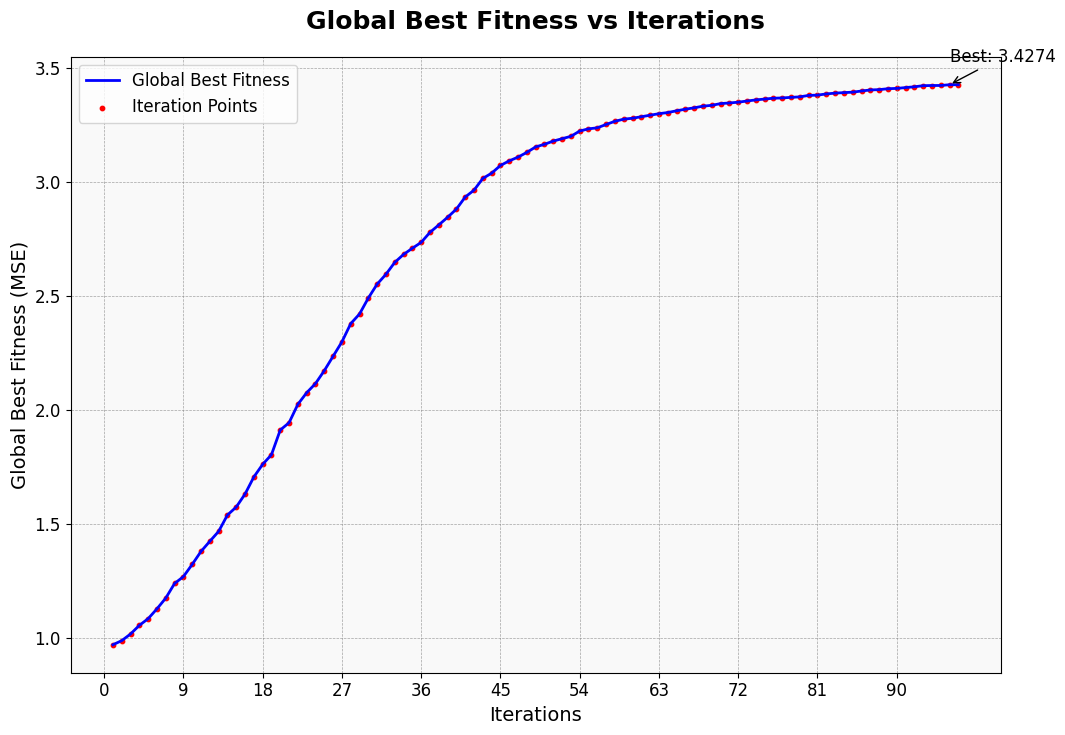

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Assume fitness_history is a list of Global Best Fitness
iterations = range(1, len(fitness_history) + 1)

# Draw the optimized image
plt.figure(figsize=(12, 8))
plt.plot(iterations, fitness_history, color='blue', linewidth=2, label='Global Best Fitness')
plt.scatter(iterations, fitness_history, color='red', s=10, label='Iteration Points')

# Add title and labels
plt.title('Global Best Fitness vs Iterations', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Global Best Fitness (MSE)', fontsize=14)

# Set up the grid and background
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')

# Add annotation for best fitness
max_fitness = max(fitness_history)
best_iteration = fitness_history.index(max_fitness) + 1
plt.annotate(f'Best: {max_fitness:.4f}', 
             xy=(best_iteration, max_fitness), 
             xytext=(best_iteration, max_fitness + 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)

# Add legend
plt.legend(fontsize=12, loc='best')

# Dynamically set axis ticks
step = max(1, len(fitness_history) // 10)
plt.xticks(np.arange(0, len(fitness_history) + 1, step=step), fontsize=12)
plt.yticks(fontsize=12)

# Save the image with a timestamp
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# plt.tight_layout()
# plt.savefig(f'global_best_fitness_{timestamp}.png', dpi=300)

plt.show()


In [218]:
ann.from_genome(best_individual.genome)
y_pred = ann.forward(X_train)
mse = np.mean((y_pred - y_test) ** 2)
print(y_pred.shape, mse)

(721, 1) 1290.7133720888278


# 4. GA Package

## 4.1 Deap

**Deap组件初始化**

In [237]:
def initialize_deap_components(neural_network, X_train, y_train, lambda_reg=0.01):
    """
    Initialize DEAP components for genetic algorithm optimization.
    :param neural_network: Instance of NeuralNetwork
    :param X_train: Training input data
    :param y_train: Training output data
    :param lambda_reg: Regularization coefficient for fitness function
    :return: Configured DEAP toolbox
    """

    # 1. Check if FitnessMin and Individual are already defined
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)  # Suppress warnings
        if hasattr(creator, "FitnessMin"):
            del creator.FitnessMin
        if hasattr(creator, "Individual"):
            del creator.Individual

    # Define the fitness function (minimization)
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Initialize the DEAP toolbox
    toolbox = base.Toolbox()

    # (1) Register gene initialization
    genome_size = len(neural_network.to_genome())  # Length of the genome (weights + biases)
    bounds = neural_network.get_bounds()  # Bounds for genome values

    def random_genome():
        """Generate a random genome within bounds."""
        return np.random.uniform(bounds[:, 0], bounds[:, 1], size=genome_size).tolist()

    toolbox.register("attr_genome", random_genome)

    # (2) Register individual and population
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_genome)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # (3) Define fitness function
    def fitness_function(genome):
        """
        Fitness function to evaluate the individual.
        :param genome: Flattened genome (weights + biases)
        :return: Negative MSE value
        """
        # Convert genome to NumPy array
        genome = np.array(genome)

        # Decode genome to neural network
        neural_network.from_genome(genome)

        # Forward propagate and calculate MSE
        predictions = neural_network.forward(X_train)
        mse = np.mean((predictions - y_train) ** 2)

        # Add L2 regularization
        l2_regularization = sum(np.sum(w ** 2) for w in neural_network.weights)
        total_loss = mse + lambda_reg * l2_regularization

        return total_loss,

    toolbox.register("evaluate", fitness_function)

    # (4) Register genetic operators
    toolbox.register("mate", tools.cxTwoPoint)  # Two-point crossover
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)  # Gaussian mutation
    toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection

    return toolbox

In [238]:
ann = NeuralNetwork(input_size=8, hidden_layers=[5, 10], output_size=1, activation_function='relu')
y_pred = ann.forward(X_train)
mse = np.mean((y_pred - y_test) ** 2)
print(mse)

1520.5276406691091


In [258]:
# 初始化 DEAP 工具箱
toolbox = initialize_deap_components(neural_network=ann, X_train=X_train, y_train=y_train, lambda_reg=0.01)

# 初始化种群
population = toolbox.population(n=50)

# 查看种群中第一个个体
print("First individual:", len(population[0]))
print("First individual's fitness (before evaluation):", population[0].fitness.values)

# 测试适应度函数
fitness = toolbox.evaluate(population[0])
print("First individual's fitness (after evaluation):", fitness)

First individual: 116
First individual's fitness (before evaluation): ()
First individual's fitness (after evaluation): (1581.9964414399535,)


**主循环**

In [253]:
def run_genetic_algorithm(toolbox, population_size, num_generations, crossover_prob, mutation_prob):
    """
    Execute the genetic algorithm main loop.
    :param toolbox: Configured DEAP toolbox
    :param population_size: Number of individuals in the population
    :param num_generations: Number of generations to run the algorithm
    :param crossover_prob: Probability of crossover
    :param mutation_prob: Probability of mutation
    :return: Final population and logbook containing statistics
    """
    # Initialize the population
    population = toolbox.population(n=population_size)

    # Statistics for tracking progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Logbook for storing evolutionary history
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + stats.fields

    # Evolutionary loop
    for gen in range(num_generations):
        # Evaluate fitness for individuals without a valid fitness
        invalid_individuals = [ind for ind in population if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
        for ind, fit in zip(invalid_individuals, fitnesses):
            ind.fitness.values = fit
    
        # Record statistics for the current generation
        record = stats.compile(population)
        logbook.record(gen=gen, nevals=len(invalid_individuals), **record)
    
        # Print logbook every 10 generations
        if (gen + 1) % 10 == 0 or gen == num_generations - 1:
            print(f"Generation {gen + 1}/{num_generations}")
            last_record = logbook[-1]  # Get the last record
            print(f"Generation {gen + 1}: {last_record}")
    
        # Select the next generation
        offspring = toolbox.select(population, len(population))
    
        # Clone the offspring
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover to offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.rand() < crossover_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
    
        # Apply mutation to offspring
        for mutant in offspring:
            if np.random.rand() < mutation_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Replace the current population with the offspring
        population[:] = offspring
    
    # Return the final population and logbook
    return population, logbook

In [259]:
# 参数设置
population_size = 50
num_generations = 100
crossover_prob = 0.7
mutation_prob = 0.2

# 执行遗传算法
final_population, logbook = run_genetic_algorithm(toolbox, population_size, num_generations, crossover_prob, mutation_prob)

Generation 10/100
Generation 10: {'gen': 9, 'nevals': 39, 'avg': 1054.1100262805305, 'std': 43.6437547405112, 'min': 979.3170096063466, 'max': 1161.8283302516845}
Generation 20/100
Generation 20: {'gen': 19, 'nevals': 42, 'avg': 826.469851240839, 'std': 19.850738969901954, 'min': 767.2480259704496, 'max': 863.4792264660449}
Generation 30/100
Generation 30: {'gen': 29, 'nevals': 38, 'avg': 674.0585283797561, 'std': 23.410020196808336, 'min': 597.1063955962223, 'max': 718.1175298470068}
Generation 40/100
Generation 40: {'gen': 39, 'nevals': 34, 'avg': 557.0785077524182, 'std': 15.126465079447696, 'min': 517.2581241981185, 'max': 597.7030638396828}
Generation 50/100
Generation 50: {'gen': 49, 'nevals': 42, 'avg': 433.8413339965206, 'std': 11.45596007418346, 'min': 395.6382742282406, 'max': 457.2939971953797}
Generation 60/100
Generation 60: {'gen': 59, 'nevals': 42, 'avg': 368.6859496569515, 'std': 5.94352806795046, 'min': 357.7590107846272, 'max': 385.0800764886459}
Generation 70/100
Gen

In [260]:
# 打印最优个体
best_individual = tools.selBest(final_population, k=1)[0]
print("Best fitness:", best_individual.fitness.values[0])

Best fitness: 307.0359511647503


## 4.2 PyGAD

## 4.3 Inspyred